# Feature Engineering

---

1. Import packages
2. Load data
3. Feature engineering

---

## 1. Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)

---
## 2. Load data

In [2]:
cleaned_data = pd.read_csv('./clean_data_after_eda.csv')
cleaned_data["date_activ"] = pd.to_datetime(cleaned_data["date_activ"], format='%Y-%m-%d')
cleaned_data["date_end"] = pd.to_datetime(cleaned_data["date_end"], format='%Y-%m-%d')
cleaned_data["date_modif_prod"] = pd.to_datetime(cleaned_data["date_modif_prod"], format='%Y-%m-%d')
cleaned_data["date_renewal"] = pd.to_datetime(cleaned_data["date_renewal"], format='%Y-%m-%d')

In [3]:
cleaned_data.head(3)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,mean_3m_price_p1_var,mean_3m_price_p2_var,mean_3m_price_p3_var,mean_3m_price_p1_fix,mean_3m_price_p2_fix,mean_3m_price_p3_fix,mean_3m_price_p1,mean_3m_price_p2,mean_3m_price_p3,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.131756,0.092638,0.036909,42.497907,12.218665,8.145777,42.629663,12.311304,8.182687,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.147600,0.000000,0.000000,44.444710,0.000000,0.000000,44.592310,0.000000,0.000000,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.167798,0.088409,0.000000,44.444710,0.000000,0.000000,44.612508,0.088409,0.000000,0


---

## 3. Feature engineering

### Difference between off-peak prices in December and preceding January

In [4]:
price_df = pd.read_csv('price_data.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [5]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


In [6]:
diff.describe()

,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
count,16096.000000,16096.000000
mean,-0.004545,0.279544
std,0.012778,1.432820
min,-0.148477,-44.266931
25%,-0.008161,0.000004
50%,-0.005610,0.162916
75%,-0.003573,0.177779
max,0.168958,40.728885


Now we merge the calculated prices to the cleaned data

In [7]:
cleaned_data_new= pd.merge(cleaned_data, diff, on='id')
cleaned_data_new.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,mean_3m_price_p3_var,mean_3m_price_p1_fix,mean_3m_price_p2_fix,mean_3m_price_p3_fix,mean_3m_price_p1,mean_3m_price_p2,mean_3m_price_p3,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.036909,42.497907,12.218665,8.145777,42.629663,12.311304,8.182687,1,0.020057,3.700961
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000000,44.444710,0.000000,0.000000,44.592310,0.000000,0.000000,0,-0.003767,0.177779
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000000,44.444710,0.000000,0.000000,44.612508,0.088409,0.000000,0,-0.004670,0.177779
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.000000,44.444710,0.000000,0.000000,44.593296,0.000000,0.000000,0,-0.004547,0.177779
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,0.073719,40.728885,24.437330,16.291555,40.848791,24.539003,16.365274,0,-0.006192,0.162916


## Average price change over Time Period

In [8]:
# Aggregate average prices per period by company
mean_prices = price_df.groupby(['id']).agg({'price_off_peak_var': 'mean', 'price_peak_var': 'mean', 
                                              'price_mid_peak_var': 'mean', 'price_off_peak_fix': 'mean', 
                                              'price_peak_fix': 'mean', 'price_mid_peak_fix': 'mean'}).reset_index()
# Calculate the mean difference between consecutive periods
mean_prices['off_peak_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_peak_var']
mean_prices['peak_mid_peak_var_mean_diff'] = mean_prices['price_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_mid_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_peak_fix']
mean_prices['peak_mid_peak_fix_mean_diff'] = mean_prices['price_peak_fix'] - mean_prices['price_mid_peak_fix']
mean_prices['off_peak_mid_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_mid_peak_fix']
columns = ['id', 'off_peak_peak_var_mean_diff', 'peak_mid_peak_var_mean_diff', 'off_peak_mid_peak_var_mean_diff', 
           'off_peak_peak_fix_mean_diff', 'peak_mid_peak_fix_mean_diff', 'off_peak_mid_peak_fix_mean_diff']

cleaned_data_new = pd.merge(cleaned_data_new, mean_prices[columns], on='id')
cleaned_data_new.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,mean_3m_price_p3,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,8.182687,1,0.020057,3.700961,0.024038,0.034219,0.058257,18.590255,7.450670,26.040925
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000000,0,-0.003767,0.177779,0.142485,0.007124,0.149609,44.311375,0.000000,44.311375
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000000,0,-0.004670,0.177779,0.082090,0.088421,0.170512,44.385450,0.000000,44.385450
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.000000,0,-0.004547,0.177779,0.151210,0.000000,0.151210,44.400265,0.000000,44.400265
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,16.365274,0,-0.006192,0.162916,0.020536,0.030773,0.051309,16.275263,8.137629,24.412893


This enhanced feature provides more granularity compared to the existing functionality, as it considers mean average price disparities across various time periods instead of just differences over the course of a year. By incorporating inter-time-period features, we can uncover patterns on a micro scale, observing variations between different months. However, the Dec-Jan feature specifically captures macro trends that unfold over the entire year. This broader time frame allows us to identify long-term patterns and trends that may not be apparent when focusing solely on shorter time intervals. By considering both micro and macro perspectives, we gain a more comprehensive understanding of the data and can potentially uncover valuable insights.

## Transform Boolean data

We simply want to transform "has_gas" column from being categorical to boolean flag

In [9]:
cleaned_data_new['has_gas'] = cleaned_data_new['has_gas'].replace(['t', 'f'], [1, 0])
cleaned_data_new.groupby(['has_gas']).agg({'churn': 'mean'})

,churn
has_gas,
0,0.100544
1,0.081887


In [10]:
#cleaned_data_new['channel_sales'] = cleaned_data_new['channel_sales'].astype('category')
#cleaned_data_new['origin_up'] = cleaned_data_new['origin_up'].astype('category')

In [12]:
remove = ['channel_sales','origin_up','date_activ', 'date_end', 'date_modif_prod', 'date_renewal']

cleaned_data_new = cleaned_data_new.drop(columns=remove)
cleaned_data_new.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,...,mean_3m_price_p3,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff
0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.00,0,0.0,1.78,0.114481,0.098142,...,8.182687,1,0.020057,3.700961,0.024038,0.034219,0.058257,18.590255,7.450670,26.040925
1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,189.95,0,0.0,16.27,0.145711,0.000000,...,0.000000,0,-0.003767,0.177779,0.142485,0.007124,0.149609,44.311375,0.000000,44.311375
2,764c75f661154dac3a6c254cd082ea7d,544,0,0,47.96,0,0.0,38.72,0.165794,0.087899,...,0.000000,0,-0.004670,0.177779,0.082090,0.088421,0.170512,44.385450,0.000000,44.385450
3,bba03439a292a1e166f80264c16191cb,1584,0,0,240.04,0,0.0,19.83,0.146694,0.000000,...,0.000000,0,-0.004547,0.177779,0.151210,0.000000,0.151210,44.400265,0.000000,44.400265
4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,445.75,526,0.0,131.73,0.116900,0.100015,...,16.365274,0,-0.006192,0.162916,0.020536,0.030773,0.051309,16.275263,8.137629,24.412893


In [13]:
cleaned_data_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14605 entries, 0 to 14604
Data columns (total 55 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               14605 non-null  object 
 1   cons_12m                         14605 non-null  int64  
 2   cons_gas_12m                     14605 non-null  int64  
 3   cons_last_month                  14605 non-null  int64  
 4   forecast_cons_12m                14605 non-null  float64
 5   forecast_cons_year               14605 non-null  int64  
 6   forecast_discount_energy         14605 non-null  float64
 7   forecast_meter_rent_12m          14605 non-null  float64
 8   forecast_price_energy_off_peak   14605 non-null  float64
 9   forecast_price_energy_peak       14605 non-null  float64
 10  forecast_price_pow_off_peak      14605 non-null  float64
 11  has_gas                          14605 non-null  int64  
 12  imp_cons          

## Checking Correlation

In [14]:
correlation = cleaned_data_new.corr()

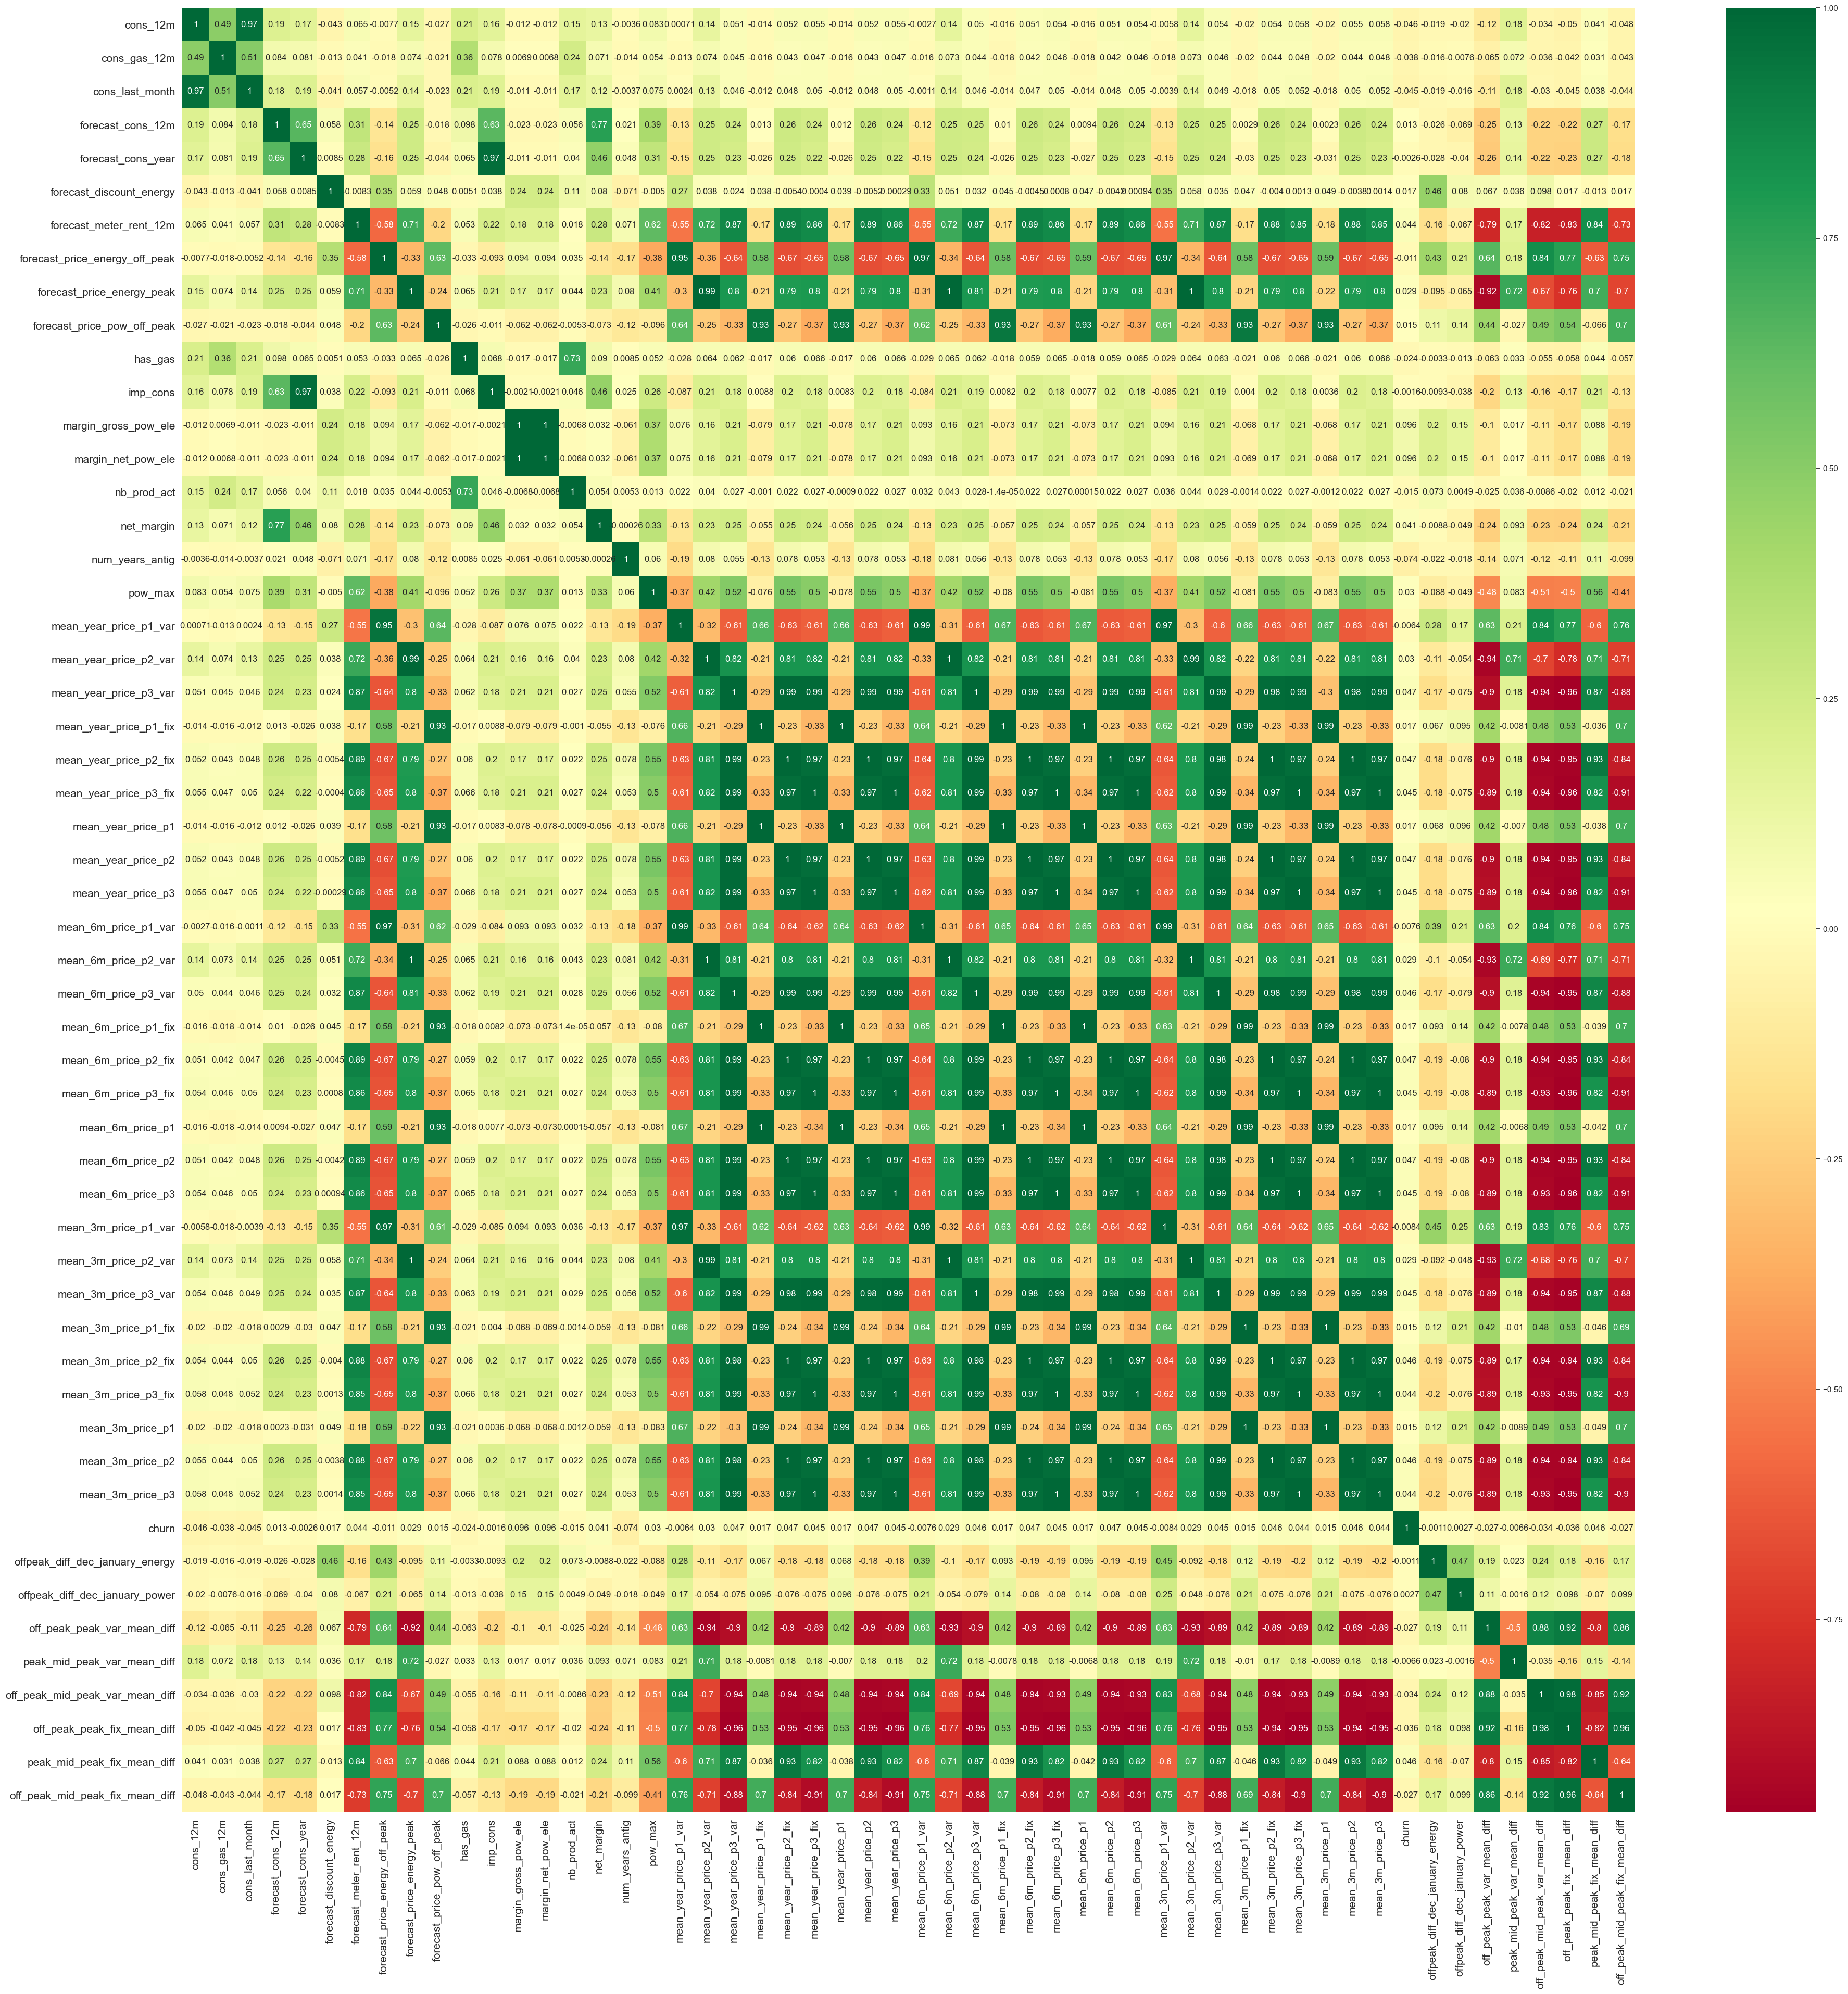

In [15]:
plt.figure(figsize=(45, 45))
sns.heatmap(
    correlation, 
    xticklabels=correlation.columns.values,
    yticklabels=correlation.columns.values, 
    annot=True, 
    annot_kws={'size': 12}, 
    cmap='RdYlGn'
)
# Axis ticks size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# View of graph
plt.show()

## Building Prediction Model using Random Forest Classifier

In [16]:
# Make a copy of our data
train_df = cleaned_data_new.copy()

# Separate target variable from independent variables
X = cleaned_data_new.drop(columns=['id', 'churn'])
y = cleaned_data_new['churn']

Splitting data in 80–20 percent between train and test

In [17]:
## Split data into train and test

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [18]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators = 1000, criterion = 'entropy', random_state = 0)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=1000, random_state=0)

## Model Evaluation
Now let's evaluate how well this trained model is able to predict the values of the test dataset.

We are going to use 3 metrics to evaluate performance:

- Accuracy = the ratio of correctly predicted observations to the total observations
- Precision = the ability of the classifier to not label a negative sample as positive
- Recall = the ability of the classifier to find all the positive samples
- ROC & AUC = It tells how much the model is capable of distinguishing between classes.
- K-Fold Cross Validation = how the results of a statistical analysis will generalize to an independent data set.

The reason why we are using these five metrics is because accuracy alone may not be sufficient to evaluate model performance, especially in cases of imbalanced datasets or when the costs of false positives and false negatives are different.

In [19]:
## prediction of test data
y_pred = rf_classifier.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report


### Model Accuracy Score

In [21]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy score:- ", accuracy)
print("\n ----- Classification Report ----- \n")
print(classification_report(y_test, y_pred))

Accuracy score:-  0.9027730229373502

 ----- Classification Report ----- 

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      2623
           1       0.89      0.05      0.10       298

    accuracy                           0.90      2921
   macro avg       0.90      0.53      0.52      2921
weighted avg       0.90      0.90      0.86      2921



### Confusion Matrix

[[2621    2]
 [ 282   16]]


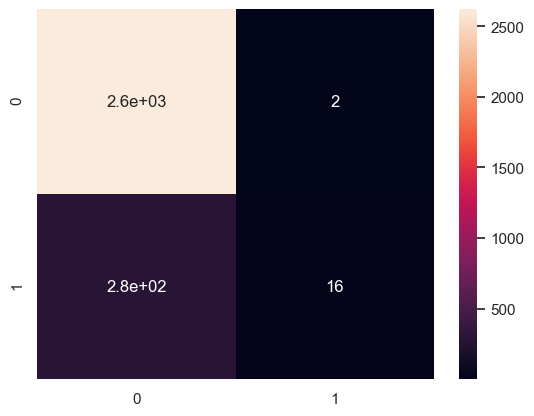

In [22]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

sns.heatmap(cm, annot=True)
plt.show()

### Precision

In [27]:
print("Precision Score - ", precision_score(y_test, y_pred))

Precision Score -  0.8888888888888888


### Recall

In [28]:
print("Recall Score - ", recall_score(y_test, y_pred))

Recall Score -  0.053691275167785234


### F1 Score

In [29]:
print("F1 Score - ", f1_score(y_test, y_pred))

F1 Score -  0.10126582278481013


### ROC/AUC

In [30]:
auc = roc_auc_score(y_test, y_pred)
print("AUC score:- ", auc)

AUC score:-  0.5264643947321961


### ROC Curve

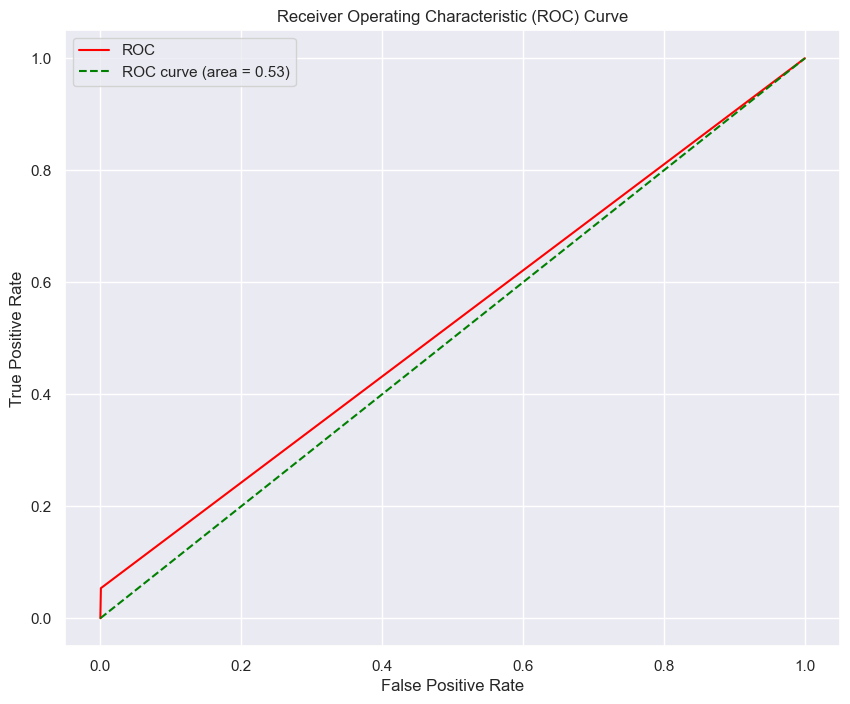

In [31]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, color='red', label='ROC')
plt.plot([0, 1], [0, 1], color='green', linestyle='--',label='ROC curve (area = %0.2f)' % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

### K-Fold Cross Validation

In [32]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(rf_classifier, X_train, y_train, cv = 4, scoring='accuracy')

print('Cross-validation scores:{}'.format(cv_scores))

Cross-validation scores:[0.90619651 0.90961999 0.90722355 0.9089353 ]


In [33]:
print('Average cross-validation score: {:.4f}'.format(cv_scores.mean()))

Average cross-validation score: 0.9080


### Model Evaluation :
- Accuracy   : 0.9027
- Precision  : 0.8888
- Recall     : 0.0537
- F1 Score   : 0.1012
- AUC        : 0.5265
- K-Fold     : 0.9080

### Examining Feature Importance


In [42]:
feature_importances = pd.DataFrame({'features': X_train.columns,'importance': rf_classifier.feature_importances_}).sort_values(by='importance', ascending=True).reset_index()

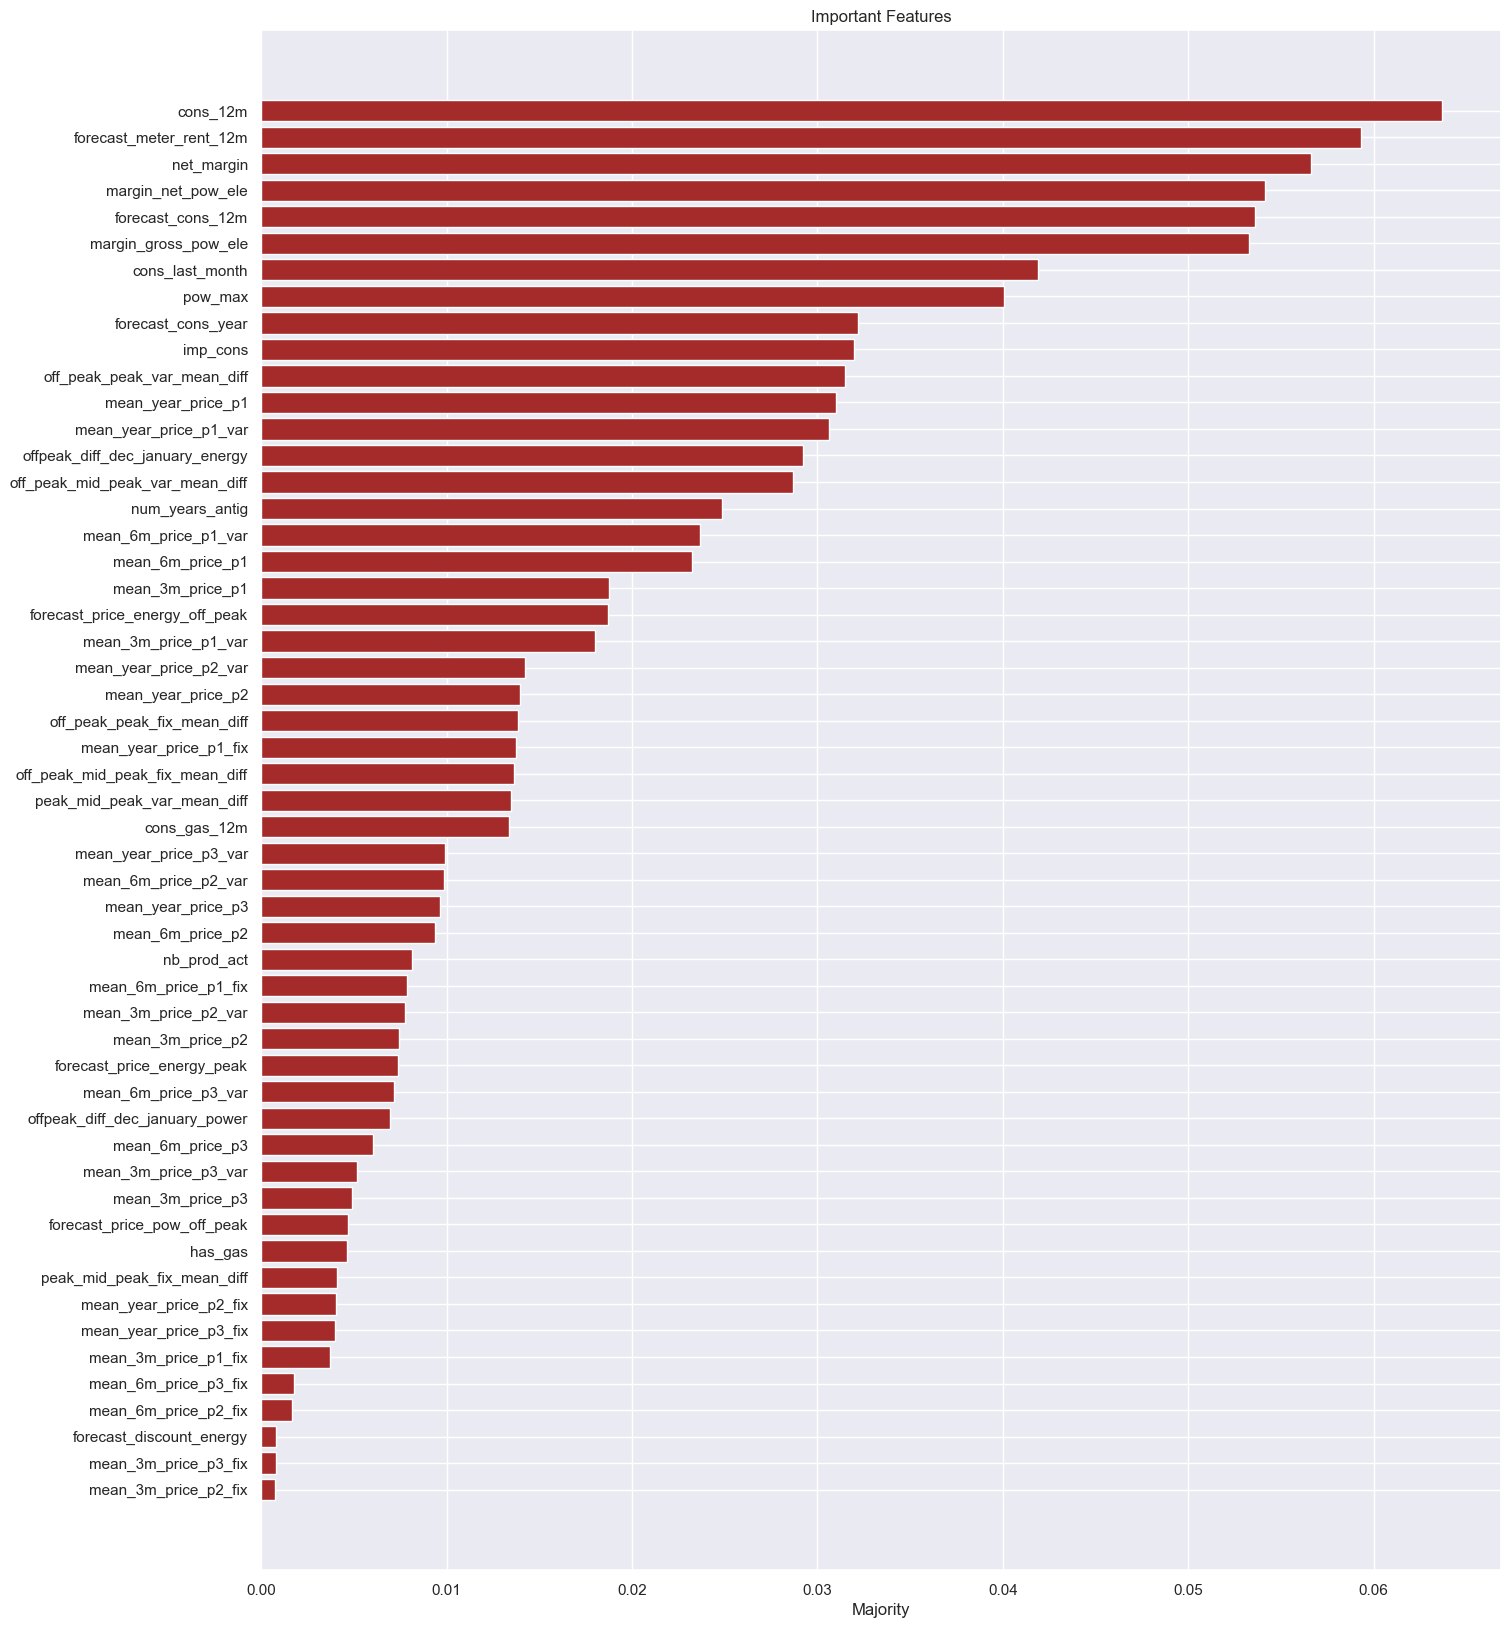

In [49]:
plt.figure(figsize=(16, 20))
plt.title('Important Features')
plt.barh(range(len(feature_importances)), feature_importances['importance'], color='brown', align='center')
plt.yticks(range(len(feature_importances)), feature_importances['features'])
plt.xlabel('Majority')
plt.show()

Based on the observations, the price sensitivity is a weak contibutor for customer churn. More research is needed to find the actual factors. 

In [52]:
proba_predictions = rf_classifier.predict_proba(X_test)
probabilities = proba_predictions[:, 1]

In [53]:
X_test = X_test.reset_index()
X_test.drop(columns='index', inplace=True)

### Saving the Predicted data

In [54]:
X_test['churn'] = y_pred.tolist()
X_test['churn_probability'] = probabilities.tolist()
X_test.to_csv('predicted_data.csv')

## Assessing the Business Impact

The client's proposed strategy to give a 20% discount to high propensity to churn customers. We can assume that everyone who is offered the proposed discount will accept it.

Now, we have to focus on forecast revenue when the following is considered:
- No Discount Offered
- 20% Discount is offered on probability basis to select customers

This helps us to decide where the cut-off should be to maximise revenue